In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
# from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR
import PIL.ImageOps    


### Boilerpalte

In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [42]:
# # First, look at everything.
# from subprocess import check_output
# print(check_output(["ls", "./data/combined_dataset/combined"]).decode("utf8"))

In [6]:
class Config():
    # training_dir = "./data/combined_dataset/combined"
    # testing_dir = "./data/combined_dataset/combined"
    
    # training_dir = "./data/sign_data/train"
    # testing_dir = "./data/sign_data/train"
    
    # training_csv="./data/combined_dataset/train_triplet_data.csv"
    # testing_csv="./data/combined_dataset/test_triplet_data.csv"
    
    # # train_batch_size = 12
    # train_batch_size = 32
    # train_number_epochs = 5


    



    training_dir = "./data/combined_dataset/gpds/combined/"
    testing_dir = "./data/combined_dataset/gpds/combined/"
    training_csv="./data/combined_dataset/gpds/train_hard_triplet_data.csv"
    testing_csv="./data/combined_dataset/gpds/train_hard_triplet_data.csv"
    
    # train_batch_size = 12
    train_batch_size = 32
    train_number_epochs = 1



In [7]:
# training_dir = "./data/combined_dataset/combined"
# testing_dir = "./data/combined_dataset/combined"

training_dir = "./data/combined_dataset/gpds/combined/"
testing_dir = "./data/combined_dataset/gpds/combined/"
training_csv="./data/combined_dataset/gpds/train_hard_triplet_data.csv"
testing_csv="./data/combined_dataset/gpds/train_hard_triplet_data.csv"

# training_csv="./data/combined_dataset/gpds/train_triplet_data.csv"
# testing_csv="./data/combined_dataset/gpds/test_triplet_data.csv"

In [8]:
# RESCALE_SIZE = 225
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [9]:
pd.read_csv(training_csv)

,sample
0,001gpds/c-001-01.jpg
1,001gpds/c-001-02.jpg
2,001gpds/c-001-03.jpg
3,001gpds/c-001-04.jpg
4,001gpds/c-001-05.jpg
...,...
539995,999gpds_forg/cf-999-26.jpg
539996,999gpds_forg/cf-999-27.jpg
539997,999gpds_forg/cf-999-28.jpg
539998,999gpds_forg/cf-999-29.jpg


In [62]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns = ['anchor', 'positive', 'negative']
        self.training_dir = training_dir    
        self.transform = transform


    def __getitem__(self,index):
        

        # getting the image path
        anchor_path = os.path.join(self.training_dir, self.training_df.iat[index,0])
        positive_path = os.path.join(self.training_dir, self.training_df.iat[index,1])
        negative_path = os.path.join(self.training_dir, self.training_df.iat[index,2])
        
        print("anchor_path:", anchor_path)
        print("positive_path:", positive_path)
        print("negative_path:", negative_path)


        # Loading the image
        anchor = Image.open(anchor_path).convert('L')
        positive = Image.open(positive_path).convert('L')
        negative = Image.open(negative_path).convert('L')

        anchor = ImageEnhance.Contrast(anchor).enhance(1.5)
        positive = ImageEnhance.Contrast(positive).enhance(1.5)
        negative = ImageEnhance.Contrast(negative).enhance(1.5)

        anchor = ImageEnhance.Brightness(anchor).enhance(1.5)
        positive = ImageEnhance.Brightness(positive).enhance(1.5)
        negative = ImageEnhance.Brightness(negative).enhance(1.5)

        anchor = PIL.ImageOps.invert(anchor)
        positive = PIL.ImageOps.invert(positive)
        negative = PIL.ImageOps.invert(negative)


        # img0 = 255 - img0
        # img1 = 255 - img1

        anchor = anchor.convert('RGB')
        positive = positive.convert('RGB')
        negative = negative.convert('RGB')
        

        anchor.load()
        positive.load()
        negative.load()

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
            
        return anchor, positive , negative
    
    def __len__(self):
        return len(self.training_df)

In [33]:
training_df['sample'][0:24]

0           001gpds/c-001-01.jpg
1           001gpds/c-001-02.jpg
2           001gpds/c-001-03.jpg
3           001gpds/c-001-04.jpg
4           001gpds/c-001-05.jpg
5           001gpds/c-001-06.jpg
6           001gpds/c-001-07.jpg
7           001gpds/c-001-08.jpg
8           001gpds/c-001-09.jpg
9           001gpds/c-001-10.jpg
10          001gpds/c-001-11.jpg
11          001gpds/c-001-12.jpg
12          001gpds/c-001-13.jpg
13          001gpds/c-001-14.jpg
14          001gpds/c-001-15.jpg
15          001gpds/c-001-16.jpg
16          001gpds/c-001-17.jpg
17          001gpds/c-001-18.jpg
18          001gpds/c-001-19.jpg
19          001gpds/c-001-20.jpg
20          001gpds/c-001-21.jpg
21          001gpds/c-001-22.jpg
22          001gpds/c-001-23.jpg
23          001gpds/c-001-24.jpg
24    001gpds_forg/cf-001-01.jpg
Name: sample, dtype: object

In [11]:
training_df=pd.read_csv(training_csv)

In [26]:
# gencounter = 1
# for i, sample in enumerate(training_df['sample'], 1):
#     print(i, sample, gencounter)
#     if (int(i) % 24) == 0 and (gencounter % 2 != 0):
#         gencounter += 1
#         print(i, sample, "genuie")
#     if (int(i) % 54) == 0:
#         print(i, sample, "forged")
#         break

In [48]:
# gencounter = 1
# for i, sample in enumerate(training_df['sample'], 1):
#     if (int(i) % 24) == 0 and (gencounter % 2 != 0):
#         gencounter += 1
#         print(training_df['sample'][i-24:i], "genuie")
#     if (int(i) % 54) == 0:
#         print(training_df['sample'][i-30:i], "forged")

gpds_forg/cf-3609-16.jpg
166678    3609gpds_forg/cf-3609-17.jpg
166679    3609gpds_forg/cf-3609-18.jpg
166680    3609gpds_forg/cf-3609-19.jpg
166681    3609gpds_forg/cf-3609-20.jpg
166682    3609gpds_forg/cf-3609-21.jpg
166683    3609gpds_forg/cf-3609-22.jpg
166684    3609gpds_forg/cf-3609-23.jpg
166685    3609gpds_forg/cf-3609-24.jpg
166686    3609gpds_forg/cf-3609-25.jpg
166687    3609gpds_forg/cf-3609-26.jpg
166688    3609gpds_forg/cf-3609-27.jpg
166689    3609gpds_forg/cf-3609-28.jpg
166690    3609gpds_forg/cf-3609-29.jpg
166691    3609gpds_forg/cf-3609-30.jpg
166692    3625gpds_forg/cf-3625-01.jpg
166693    3625gpds_forg/cf-3625-02.jpg
166694    3625gpds_forg/cf-3625-03.jpg
166695    3625gpds_forg/cf-3625-04.jpg
166696    3625gpds_forg/cf-3625-05.jpg
166697    3625gpds_forg/cf-3625-06.jpg
Name: sample, dtype: object forged
166722    3641gpds_forg/cf-3641-01.jpg
166723    3641gpds_forg/cf-3641-02.jpg
166724    3641gpds_forg/cf-3641-03.jpg
166725    3641gpds_forg/cf-3641-04.jpg
1667

KeyboardInterrupt: 

In [81]:
class HardTripletDataset():
    
    def __init__(self, transform=None, model=None):

        self.transform = transform
        self.model = model
        self.genuie = []
        self.forged = []

        self.base_path = '/storage/Study/DBO/project/data/combined_dataset/gpds/combined'
        dataframes = []
        files_list = []

        for root, dirs, files in tqdm(os.walk(self.base_path)):
            if files:
                dataframes.append([os.path.join(root.split("/")[-1], file) for file in files ])

        for i in tqdm(range(10)):
            if '_forg' not in dataframes[i][0]:
                cur_genuie = dataframes[i]

                for j, dataframe in enumerate(dataframes):
                    if dataframes[i][0].split("/")[0]+"_forg" == dataframes[j][0].split("/")[0]:
                        cur_forg = dataframes[j]
                        break 
                        
                self.genuie.append(cur_genuie)
                self.forged.append(cur_forg)



    def __getitem__(self, index):
        cur_genuie = self.genuie[index]
        cur_forged = self.forged[index]

        print(len(cur_genuie))
        print(len(cur_forged))

        cur_genuie_batch = self.prepare_batch(cur_genuie)
        cur_forged_batch = self.prepare_batch(cur_forged)

        print(cur_genuie_batch.size(), cur_forged_batch.size())
        return cur_genuie_batch, cur_forged_batch
    

    def prepare_batch(self, batch):
        for n, i in enumerate(batch):
            print(i)
            cur_img = Image.open(os.path.join(self.base_path,i)).convert('L')
            cur_img = ImageEnhance.Contrast(cur_img).enhance(1.5)
            cur_img = ImageEnhance.Brightness(cur_img).enhance(1.5)
            cur_img = PIL.ImageOps.invert(cur_img)
            cur_img = cur_img.convert('RGB')
            cur_img.load()

            if self.transform is not None:
                cur_img = self.transform(cur_img)

            if n == 0:
                prepared_batch = cur_img.unsqueeze(0)
            else:
                prepared_batch = torch.cat((prepared_batch, cur_img.unsqueeze(0)), 0)
            
            print(prepared_batch.size())
        return prepared_batch
        

    def __len__(self):
        return len(self.training_df)

In [82]:
debug_datasdet = HardTripletDataset(transform=transform)

20001it [00:02, 7608.59it/s]
100%|██████████| 10/10 [00:00<00:00, 67324.30it/s]


In [83]:
debug_datasdet[0][1].size()

24
30
001gpds/c-001-01.jpg
torch.Size([1, 3, 224, 224])
001gpds/c-001-02.jpg
torch.Size([2, 3, 224, 224])
001gpds/c-001-03.jpg
torch.Size([3, 3, 224, 224])
001gpds/c-001-04.jpg
torch.Size([4, 3, 224, 224])
001gpds/c-001-05.jpg
torch.Size([5, 3, 224, 224])
001gpds/c-001-06.jpg
torch.Size([6, 3, 224, 224])
001gpds/c-001-07.jpg
torch.Size([7, 3, 224, 224])
001gpds/c-001-08.jpg
torch.Size([8, 3, 224, 224])
001gpds/c-001-09.jpg
torch.Size([9, 3, 224, 224])
001gpds/c-001-10.jpg
torch.Size([10, 3, 224, 224])
001gpds/c-001-11.jpg
torch.Size([11, 3, 224, 224])
001gpds/c-001-12.jpg
torch.Size([12, 3, 224, 224])
001gpds/c-001-13.jpg
torch.Size([13, 3, 224, 224])
001gpds/c-001-14.jpg
torch.Size([14, 3, 224, 224])
001gpds/c-001-15.jpg
torch.Size([15, 3, 224, 224])
001gpds/c-001-16.jpg
torch.Size([16, 3, 224, 224])
001gpds/c-001-17.jpg
torch.Size([17, 3, 224, 224])
001gpds/c-001-18.jpg
torch.Size([18, 3, 224, 224])
001gpds/c-001-19.jpg
torch.Size([19, 3, 224, 224])
001gpds/c-001-20.jpg
torch.Size([2

torch.Size([30, 3, 224, 224])

In [9]:
transform = transforms.Compose([
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
      

              # transforms.RandomRotation(degrees = 10, fill=255),
            #   transforms.RandomRotation(degrees = 20),
              # transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              # transforms.RandomRotation(degrees = 15, fill=0),
            # transforms.RandomAffine(degrees=(-10, 10), translate=None, scale=None, shear=(-10,10), resample=False, fillcolor=(0,0,0)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.95, 1.05)),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              # transforms.Resize((448,448)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.9, 1.4)),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [64]:
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)

anchor_path: ./data/combined_dataset/gpds/combined/027gpds/c-027-14.jpg
positive_path: ./data/combined_dataset/gpds/combined/027gpds/c-027-22.jpg
negative_path: ./data/combined_dataset/gpds/combined/027gpds_forg/cf-027-17.jpg


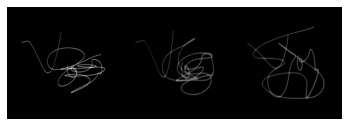

In [102]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

### ResNet Siamese

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        # self.resnet = models.resnet50(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                # nn.Linear(num_ftrs, 512),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # nn.Linear(512, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # # nn.Linear(128,16)
                # nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

    def inference(self, x):
        with torch.no_grad():
            output = self.resnet(x)
            return output

In [13]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

    # for param in model.layer3.parameters():
    #   param.requires_grad = True
    
    # for param in model.layer4.parameters():
    #   param.requires_grad = True

    # for param in model.avgpool.parameters():
    #   param.requires_grad = True

    # for param in model.fc.parameters():
    #   param.requires_grad = True

In [14]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
        
#         self.resnet = models.inception_v3(pretrained=False)
#         set_parameter_requires_grad(self.resnet)
#         # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
#         # self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
#         num_ftrs = self.resnet.fc.in_features
#         self.resnet.fc = nn.Sequential(
#                 nn.Linear(num_ftrs, 16),
#                 # nn.Linear(num_ftrs, 512),
#                 # nn.ReLU(inplace=True),
#                 # nn.Dropout2d(p=0.5),
#                 # nn.Linear(512, 128),
#                 # nn.ReLU(inplace=True),
#                 # nn.Dropout2d(p=0.5),
#                 # # nn.Linear(128,16)
#                 # nn.Linear(128,2)
#             )
        
#     def forward_once(self, x):
#         output = self.resnet(x)
#         return output

#     def forward(self, input1, input2):
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2


In [15]:
# def set_parameter_requires_grad(model):
#     for param in model.parameters():
#         param.requires_grad = True

#     # for param in model.layer3.parameters():
#     #   param.requires_grad = True
    
#     # for param in model.layer4.parameters():
#     #   param.requires_grad = True

#     # for param in model.avgpool.parameters():
#     #   param.requires_grad = True

#     # for param in model.fc.parameters():
#     #   param.requires_grad = True

In [16]:
net = SiameseNetwork().cuda()
train_dataset = SiameseNetworkDataset(training_csv=Config.training_csv, training_dir=Config.training_dir, transform=transform)

In [17]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### Loss

In [18]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

### Train

In [19]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [20]:
# def fit_epoch(net, train_loader, criterion, optimizer):
#     running_loss = 0.0
#     running_corrects = 0
#     processed_data = 0
  
#     log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  

#     with tqdm(desc="iteration", total=len(train_loader)) as pbar_outer:
#         for i, data in enumerate(train_loader,0):
#             img0, img1, img2 = data
#             img0, img1, img2 = img0.cuda(), img1.cuda() , img2.cuda()
#             optimizer.zero_grad()
#             output1, output2, output3 = net(img0, img1, img2)
#             loss_contrastive = criterion(output1, output2, output3)
#             loss_contrastive.backward()
#             optimizer.step()

#             running_loss += loss_contrastive.item() * data[0].size(0)
#             processed_data += data[0].size(0)

#             pbar_outer.update(1)
#             tqdm.write(log_template.format(ep=i+1, t_loss=loss_contrastive.item()))
              
#     train_loss = running_loss / processed_data

#     return train_loss

In [21]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  
    
    for i, data in tqdm(enumerate(train_loader,0), total = len(train_loader)):
        img0, img1, img2 = data
        img0, img1, img2 = img0.cuda(), img1.cuda() , img2.cuda()
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1, img2)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()

        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
          
    train_loss = running_loss / processed_data

    return train_loss

In [22]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
   
    opt = optim.AdamW(net.parameters(), lr=0.05)
    scheduler = StepLR(opt, step_size=1, gamma=0.5)
    criterion = TripletLoss()
    # criterion = nn.TripletMarginLoss(margin = 100.0, p = 1.0, eps = 1e-06, swap = False, size_average=None, reduce=None, reduction = 'mean')

    for epoch in range(epochs):
        print("Epoch:", epoch)
        train_loss = fit_epoch(net, train_dataloader, criterion, opt)
        print("loss:", train_loss)
        
        scheduler.step()
        history.append((train_loss))
                 
    return history

In [23]:
history = train(train_dataset, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)

Epoch: 0
100%|██████████| 2588/2588 [38:32<00:00,  1.12it/s]loss: 235.98807388035212



In [24]:
torch.save(net.state_dict(), "model.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [25]:
# # Load the saved model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [26]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 10),
            #   transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              # transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [27]:
# test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir, transform=transform)
test_dataset = SiameseNetworkDataset(training_csv=training_csv,training_dir=testing_dir, transform=transform)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [28]:
from tqdm import tqdm

In [29]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
threshhold = torch.FloatTensor([200.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1, x3 = data
    output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
    eucledian_distance1 = F.pairwise_distance(output1, output2)
    eucledian_distance2 = F.pairwise_distance(output1, output3)
    
    targets.append(0)
    targets.append(1)
    
    if eucledian_distance1 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

    if eucledian_distance2 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

27%|██▋       | 22414/82800 [10:07<27:16, 36.89it/s]


KeyboardInterrupt: 

In [36]:
from sklearn.metrics import f1_score

In [37]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5

In [ ]:
f1_score(n_targets, n_predictions, average='weighted')

In [ ]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

In [ ]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

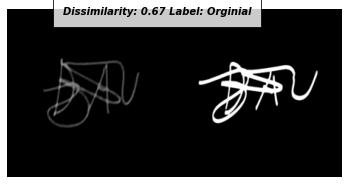

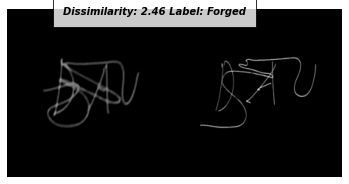

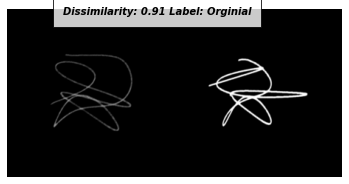

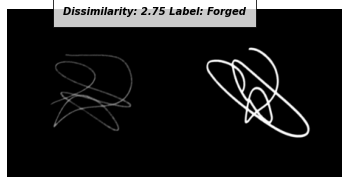

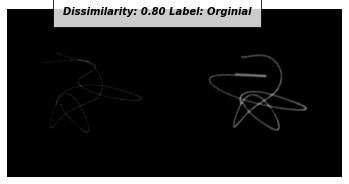

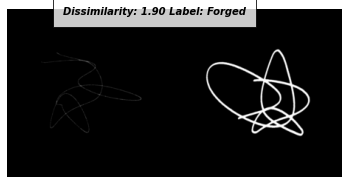

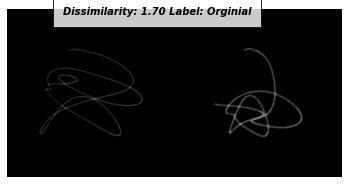

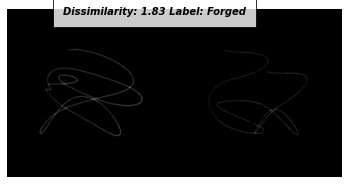

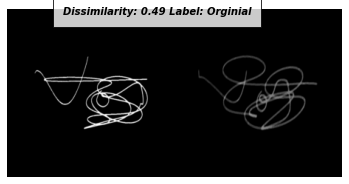

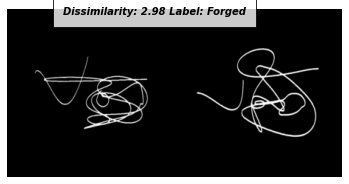

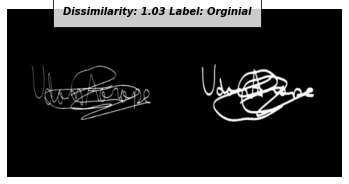

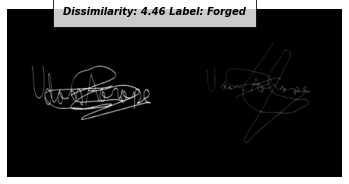

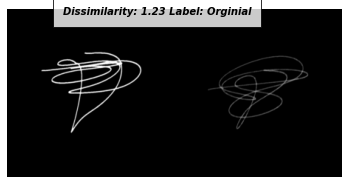

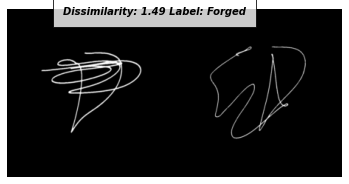

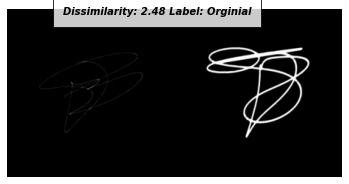

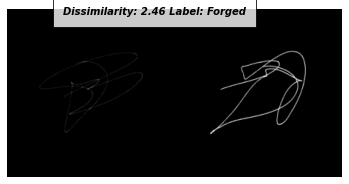

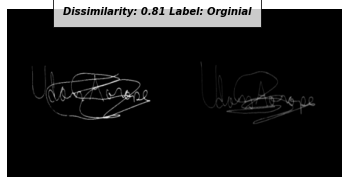

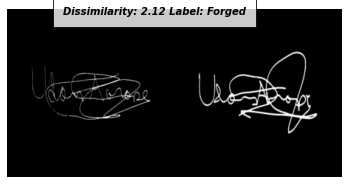

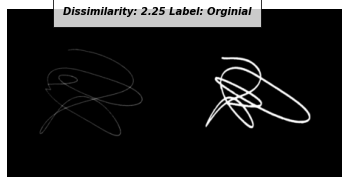

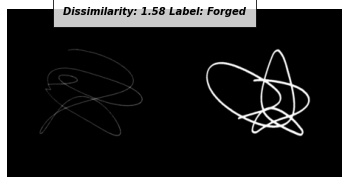

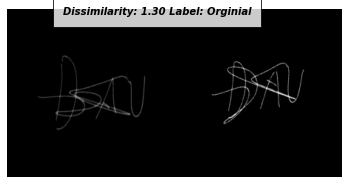

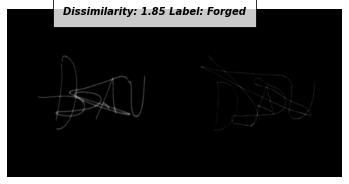

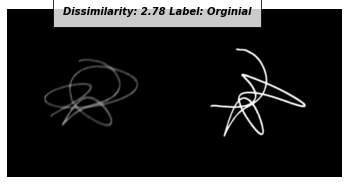

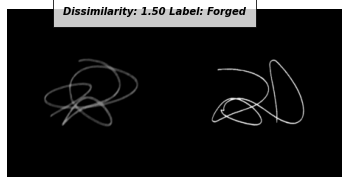

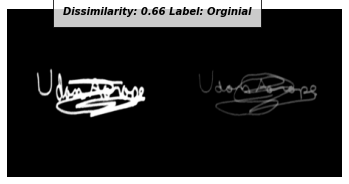

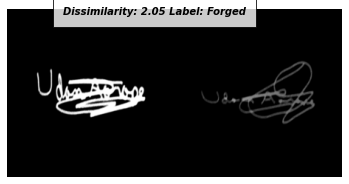

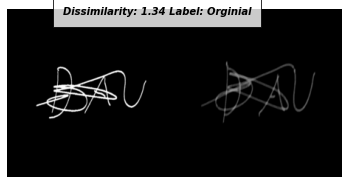

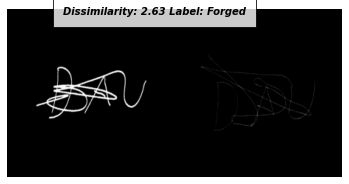

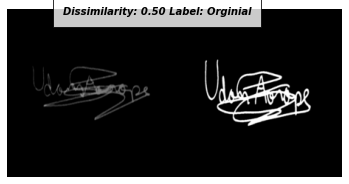

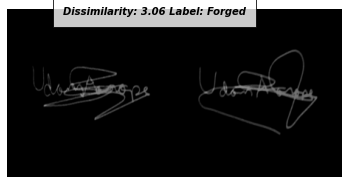

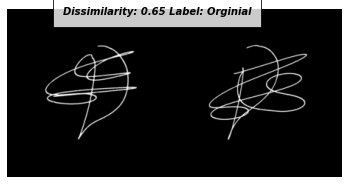

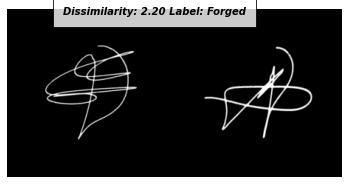

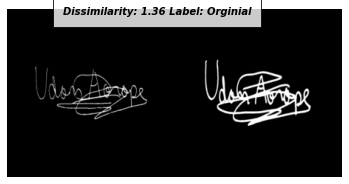

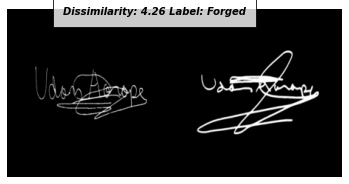

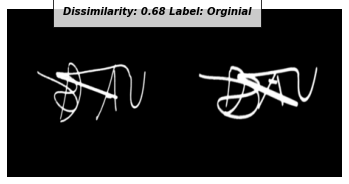

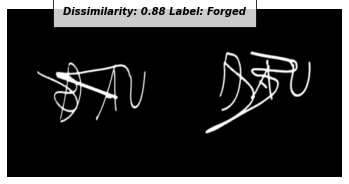

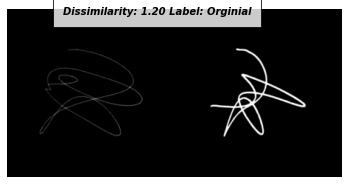

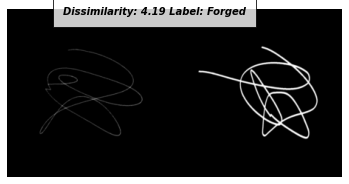

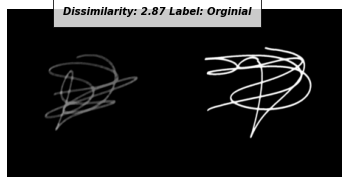

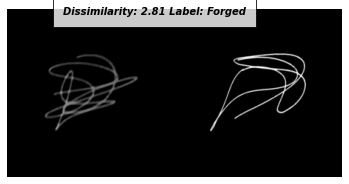

In [39]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 ,x3 = data
  concatenated1 = torch.cat((x0,x1),0)
  concatenated2 = torch.cat((x0,x3),0)
  output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
  eucledian_distance1 = F.pairwise_distance(output1, output2)
  eucledian_distance2 = F.pairwise_distance(output1, output3)
  label="Orginial"
  imshow(torchvision.utils.make_grid(concatenated1),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance1.item(),label))
  label="Forged"
  imshow(torchvision.utils.make_grid(concatenated2),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance2.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [ ]:
# Gridsearch границы forged/original
# tiplet loss
# accuracy
# concat datasets

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Public kernel: https://www.kaggle.com/robinreni/signature-classification-using-siamese-pytorch 